# Importando Bibliotecas

In [28]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import time
import psutil
from tensorflow.keras.callbacks import Callback
from skimage.feature import local_binary_pattern

# Montando o Diretório



In [29]:
# Diretórios principais
base_dir = "D:\\T.I\\BootcampAvanti_ML\\DeteccaoMelanoma_ML"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Definição dos Parâmetros

In [30]:
# Parâmetros
IMAGE_SIZE = 224
BATCH_SIZE = 32        
EPOCHS = 5 # apenas para testar o modelo.          
CHANNELS = 3            


# Carregamento dos dados

In [31]:
# Carregar o dataset de treino
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Carregar o dataset de teste
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [32]:
class_names=train_dataset.class_names
class_names

['Benign', 'Malignant']

In [33]:
len(train_dataset)

372

In [34]:
for image_batch,label_batch in train_dataset.take(1):
    print(label_batch.numpy())
    print(image_batch[0].numpy())

[1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0]
[[[160. 131. 133.]
  [161. 132. 134.]
  [162. 133. 135.]
  ...
  [161. 138. 124.]
  [163. 140. 126.]
  [166. 143. 129.]]

 [[163. 134. 136.]
  [163. 134. 136.]
  [165. 136. 138.]
  ...
  [163. 140. 126.]
  [165. 142. 128.]
  [167. 144. 130.]]

 [[166. 137. 139.]
  [167. 138. 140.]
  [168. 139. 141.]
  ...
  [167. 141. 128.]
  [168. 142. 129.]
  [170. 144. 131.]]

 ...

 [[186. 161. 157.]
  [185. 160. 156.]
  [185. 160. 156.]
  ...
  [165. 135. 133.]
  [165. 135. 133.]
  [166. 136. 134.]]

 [[190. 165. 160.]
  [188. 163. 158.]
  [186. 161. 156.]
  ...
  [166. 135. 132.]
  [165. 134. 131.]
  [166. 135. 132.]]

 [[194. 169. 164.]
  [191. 166. 161.]
  [187. 162. 157.]
  ...
  [166. 135. 132.]
  [166. 135. 132.]
  [166. 135. 132.]]]


# Visualização dos Dados

#### Visualizando os dados

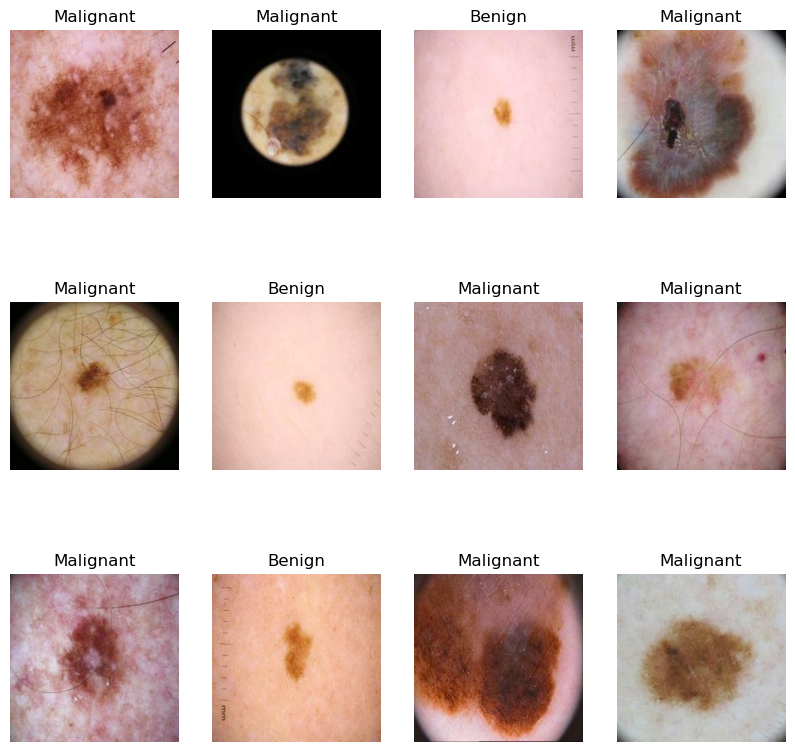

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_dataset.take(1):
    class_names = train_dataset.class_names
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

#### Visualizando os dados com o pré-processamento

In [ ]:
## Não consegui visualizar as imagens com o pré processamento desejado.

In [20]:
# # Deletando o train_dataset_temporario

# del train_dataset_temporario
# import gc
# gc.collect()  # Forçar coleta de lixo para liberar a memória

36645

# Particionamento dos Dados

In [35]:
def get_dataset_partitation(ds, train_split=0.8, valid_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + valid_split <= 1), "As proporções de treinamento e validação devem somar no máximo 1"
    
    ds_size = len(ds)
    if ds_size == 0:
        raise ValueError("O dataset está vazio.")
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    valid_size = int(ds_size * valid_split)
    
    if train_size + valid_size > ds_size:
        raise ValueError("Os tamanhos de particionamento excedem o tamanho do dataset.")
    
    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)

    return train_ds, valid_ds

In [36]:
train_ds,valid_ds=get_dataset_partitation(train_dataset)

In [37]:
len(train_ds)

297

In [38]:
len(test_dataset)

63

In [39]:
len(valid_ds)

37

# Otimização do Carregamento de Imagens

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Redimensionando tamanho e escala

In [41]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Aumento de Dados (Data Augmentation)

In [42]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)) # Vamos testar com zoom
])

# Pré-Processamento das imagens

In [56]:
class GrayscaleLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(GrayscaleLayer, self).__init__()

    def call(self, inputs):
        return tf.image.rgb_to_grayscale(inputs)


In [19]:
# import tensorflow as tf
# import numpy as np
# from skimage.feature import local_binary_pattern

# # Função LBP aplicada em NumPy
# def apply_lbp_np(image_np):
#     lbp_image = local_binary_pattern(image_np.squeeze(), P=8, R=1, method='uniform')
#     lbp_image = np.expand_dims(lbp_image, axis=-1)  # Adicionar a dimensão extra
#     return lbp_image

# # Função wrapper para tf.numpy_function
# def tf_apply_lbp(image):
#     def wrapper(image_np):
#         return apply_lbp_np(image_np)
    
#     image_np = tf.image.convert_image_dtype(image, dtype=tf.float32).numpy()
#     lbp_image = wrapper(image_np)
#     return tf.convert_to_tensor(lbp_image, dtype=tf.float32)

# class LBPPreprocessingLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super(LBPPreprocessingLayer, self).__init__()

#     def call(self, inputs):
#         # Wrapper para tf.numpy_function
#         return tf.numpy_function(tf_apply_lbp, [inputs], tf.float32)

#     def compute_output_shape(self, input_shape):
#         return input_shape

# # Testando a camada personalizada separadamente
# IMAGE_SIZE = 224  # Defina o tamanho da imagem
# CHANNELS = 1      # Número de canais

# test_image = tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=tf.float32)
# lbp_layer = LBPPreprocessingLayer()
# output = lbp_layer(test_image)
# print("Shape da saída:", output.shape)


Shape da saída: (224, 224, 1)


d:\T.I\Anaconda\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [57]:
import tensorflow as tf

def histogram_equalization_tf(image):
    # Garantir que a imagem está no formato float32 e normalizar
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    # Reduzir a dimensão para calcular o histograma
    image = tf.squeeze(image, axis=-1)  # Remover o canal de cor para o cálculo do histograma
    
    # Calcular o histograma
    hist = tf.histogram_fixed_width(image, value_range=[0.0, 1.0], nbins=256)
    
    # Calcular a CDF
    cdf = tf.cumsum(hist)
    cdf = cdf / tf.reduce_max(cdf)  # Normalizar CDF
    
    # Mapeamento da imagem com a CDF
    image_eq = tf.gather(cdf, tf.cast(image * 255, tf.int32))
    
    # Adicionar de volta a dimensão de canal e normalizar a imagem
    image_eq = tf.expand_dims(image_eq, axis=-1)
    return image_eq

class HistogramEqualizationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(HistogramEqualizationLayer, self).__init__()

    def call(self, inputs):
        return histogram_equalization_tf(inputs)


# Construindo o Modelo

#### Construindo função para monitorar treinamento

In [58]:
class ResourceMonitor(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.process = psutil.Process()
        self.cpu_usages = []
        self.memory_usages = []
        self.logs = {
            "epoch": [],
            "cpu_usage": [],
            "memory_usage": [],
            "elapsed_time": []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Capture CPU and memory usage at the end of each epoch
        cpu_usage = self.process.cpu_percent(interval=None)
        memory_info = self.process.memory_info()
        memory_usage = memory_info.rss / (1024 * 1024)  # Convert bytes to MB
        elapsed_time = time.time() - self.train_start_time
        
        self.cpu_usages.append(cpu_usage)
        self.memory_usages.append(memory_usage)

        # Store in logs
        self.logs["epoch"].append(epoch + 1)
        self.logs["cpu_usage"].append(cpu_usage)
        self.logs["memory_usage"].append(memory_usage)
        self.logs["elapsed_time"].append(elapsed_time)

        print(f"Epoch {epoch + 1}: CPU usage: {cpu_usage}%, Memory usage: {memory_usage} MB, Elapsed time: {elapsed_time:.2f} seconds")
    
    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        self.total_training_time = self.train_end_time - self.train_start_time
        print(f"Total training time: {self.total_training_time:.2f} seconds")
        print(f"Average CPU usage: {sum(self.cpu_usages) / len(self.cpu_usages):.2f}%")
        print(f"Average Memory usage: {sum(self.memory_usages) / len(self.memory_usages):.2f} MB")
        
        # Store final training time
        self.logs["total_training_time"] = self.total_training_time
        self.logs["average_cpu_usage"] = sum(self.cpu_usages) / len(self.cpu_usages)
        self.logs["average_memory_usage"] = sum(self.memory_usages) / len(self.memory_usages)
    
    def get_logs(self):
        return self.logs

### Construção do modelo

#### Modelo com 64 Neurônios

In [59]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model_64 = tf.keras.Sequential([
    layers.Input(shape=input_shape),  # Adicionando a forma de entrada
    GrayscaleLayer(),
    HistogramEqualizationLayer(),  # Camada de pré-processamento personalizada
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_64.build(input_shape=(None,) + input_shape)

model_64.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grayscale_layer_2               │ (None, 224, 224, 1)    │             0 │
│ (GrayscaleLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ histogram_equalization_layer_2  │ (None, 224, 224, 1)    │             0 │
│ (HistogramEqualizationLayer)    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,178 (1.84 MB)

 Trainable params: 482,178 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

#### Modelo com 512 Neurônios

In [ ]:
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 2

# model_512 = tf.keras.Sequential([
#     layers.Input(shape=input_shape),  # Adicionando a forma de entrada
#     preprocess_image_layer,  # Camada de pré-processamento personalizada
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])

# model_512.build(input_shape=(None,) + input_shape)

# model_512.summary()


# Compilando e Treinando o modelo

#### Compilando o modelo

In [60]:
# Compilando o modelo

model_64.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### Instanciação do callback de monitoramento de recursos

In [61]:
resource_monitor = ResourceMonitor()

#### Treinando o modelo

In [62]:
# Treinamento do modelo
history = model_64.fit(
    train_ds,  # Dados de treinamento
    epochs=EPOCHS,  # Número de épocas
    validation_data=valid_ds,  # Dados de validação
    batch_size=BATCH_SIZE,  # Tamanho do lote
    verbose=1,  # Nível de verbosidade
    callbacks=[resource_monitor]
)

# Converter os logs para um DataFrame
logs = resource_monitor.get_logs()
df = pd.DataFrame(logs)
print(df)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sequential_10_1/histogram_equalization_layer_2_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "d:\T.I\Anaconda\Lib\asyncio\base_events.py", line 607, in run_forever

  File "d:\T.I\Anaconda\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "d:\T.I\Anaconda\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\User\AppData\Local\Temp\ipykernel_16868\2255492542.py", line 2, in <module>

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 318, in fit

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\models\sequential.py", line 209, in call

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py", line 175, in call

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py", line 556, in call

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\User\AppData\Local\Temp\ipykernel_16868\1440075637.py", line 29, in call

  File "C:\Users\User\AppData\Local\Temp\ipykernel_16868\1440075637.py", line 18, in histogram_equalization_tf

indices[18,0,0] = 41014 is not in [0, 256)
	 [[{{node sequential_10_1/histogram_equalization_layer_2_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_10315]

#### Monitorando o Treinamento

- coleta e armazenamento de métricas de uso de recursos do sistema durante o treinamento do modelo

In [28]:
df.to_csv('resource_usage_log_model64_50ep.csv', index=False)

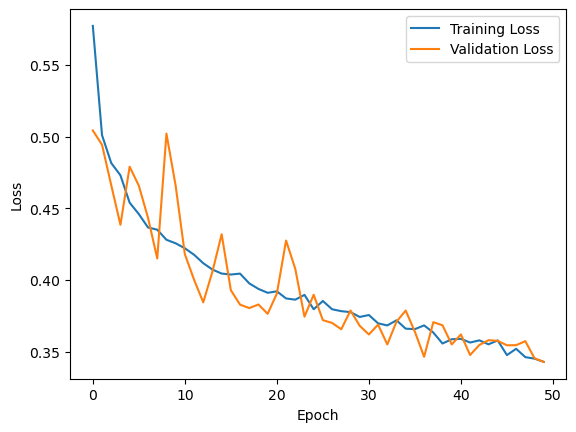

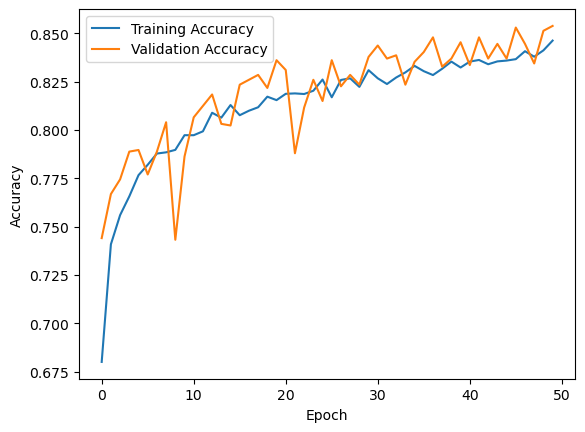

In [29]:
# Plotar a perda de treinamento e validação
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar a acurácia de treinamento e validação
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Salvando o modelo

#### Salvando o modelo completo

In [30]:
# Salvar o modelo completo no formato Keras nativo
model_64.save('Model_64_50pe.keras')


#### Salvando os pesos

In [ ]:
# Salvar apenas os pesos
model_64.save_weights('meus_pesos_modelo.h5')
# Deu pau kkkkk

# Avaliar o modelo no conjunto de Test

In [31]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model_64.evaluate(test_dataset)
print(f"Perda no teste: {test_loss:.4f}")
print(f"Acurácia no teste: {test_accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.8670 - loss: 0.3032
Perda no teste: 0.3273
Acurácia no teste: 0.8565


In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


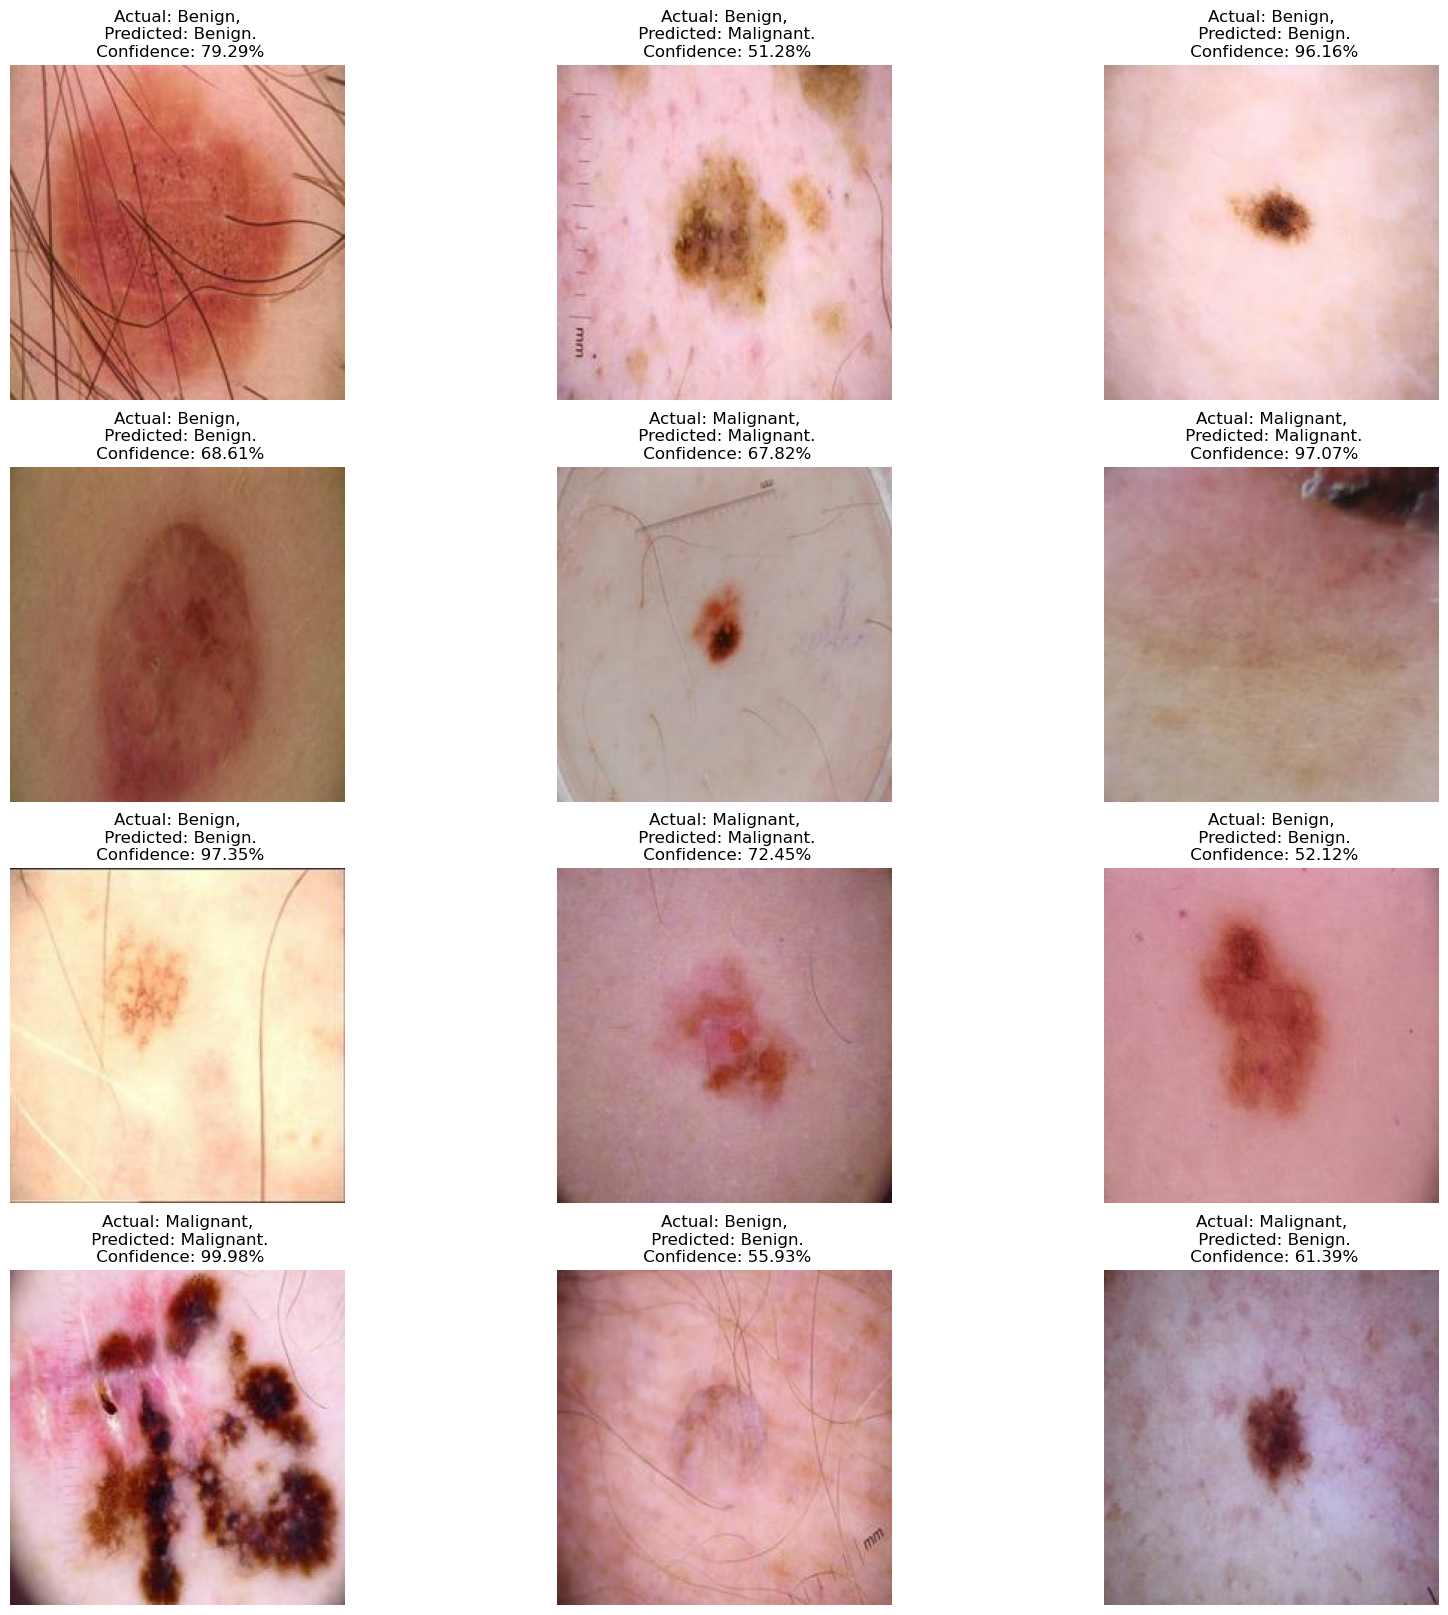

In [33]:
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_64, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [34]:
def evaluate_model(model, test_dataset):
    # Avaliar o modelo no conjunto de teste
    scores = model.evaluate(test_dataset)
    print(f"Loss: {scores[0]}")
    print(f"Accuracy: {scores[1]}")
    
    # Obter previsões
    y_true = []
    y_pred = []
    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(model.predict(images), axis=-1))
    
    # Relatório de classificação
    print("Classification Report")
    class_report = classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno'], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    metrics = {
        "loss": scores[0],
        "accuracy": scores[1],
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "classification_report": class_report
    }
    
    # Converter as métricas em um DataFrame
    metrics_df = pd.DataFrame([metrics])
    
    return metrics_df

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.8754 - loss: 0.3075
Loss: 0.33109042048454285
Accuracy: 0.8575000166893005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━

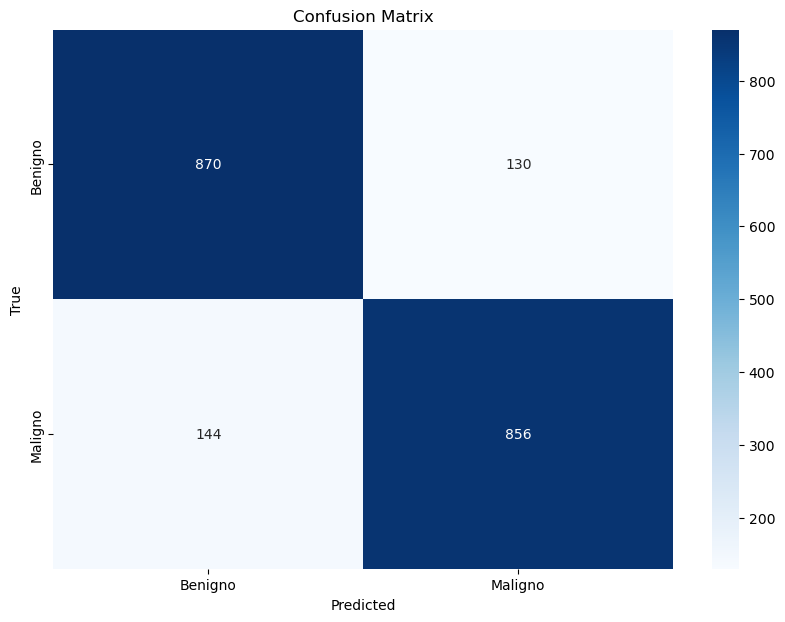

,loss,accuracy,precision,recall,f1_score,classification_report
0,0.33109,0.8575,0.863071,0.863,0.862993,"{'Benigno': {'precision': 0.8579881656804734, ..."


In [35]:
# Avaliar o modelo e obter as métricas
metrics_df = evaluate_model(model_64, test_dataset)
display(metrics_df)

#### Salvando o relatório

In [36]:
# Salvar o DataFrame em um arquivo CSV
metrics_df.to_csv('model64_50pe_metrics.csv', index=False)

In [ ]:
# # Criar DataFrame com a matriz de confusão
# df_cm = pd.DataFrame(cm, index=['Benign', 'Malignant'], columns=['Benign', 'Malignant'])

# # Salvar o DataFrame como CSV
# df_cm.to_csv('matriz_confusao.csv')

# # Salvar o relatório de classificação como texto
# with open('relatorio_classificacao.txt', 'w') as f:
#     f.write(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))